In [4]:
import os
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from openpiv import preprocess
from openpiv import tools as tools_piv

from lhcpiv import tools, velocity_vectors

In [6]:
videos = tools.transform_all_videos_to_frames(qty_frames=50)

Success


In [7]:
videos[list(videos.keys())[0]][0]

'20220212230118'

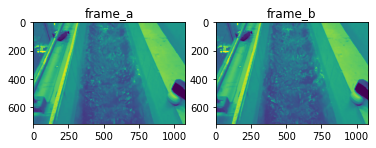

In [39]:
first_frame = 12
frame_a = tools_piv.imread(
    os.path.join(
        "data",
        list(videos.keys())[0],
        videos[list(videos.keys())[0]][0],
        f"frame{str(first_frame).zfill(6)}.jpg",
    )
)
frame_b = tools_piv.imread(
    os.path.join(
        "data",
        list(videos.keys())[0],
        videos[list(videos.keys())[0]][0],
        f"frame{str(first_frame + 1).zfill(6)}.jpg",
    )
)

plt.subplot(121), plt.imshow(frame_a), plt.title("frame_a")
plt.subplot(122), plt.imshow(frame_b), plt.title("frame_b")
plt.show()

In [22]:
pixel_coords = np.loadtxt(
    f"data/{list(videos.keys())[0]}/points.txt", delimiter=","
).astype(np.float32)

real_coords = np.float32(
    [
        [0, 0],
        [400, 0],
        [400, 508],
        [0, 508],
    ]
)

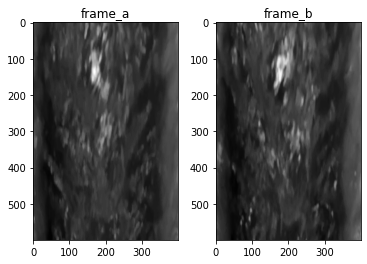

In [23]:
first_frame = 5
frame_a = tools_piv.imread(
    os.path.join(
        "data",
        list(videos.keys())[0],
        videos[list(videos.keys())[0]][0],
        f"frame{str(first_frame).zfill(6)}.jpg",
    )
)
frame_b = tools_piv.imread(
    os.path.join(
        "data",
        list(videos.keys())[0],
        videos[list(videos.keys())[0]][0],
        f"frame{str(first_frame + 1).zfill(6)}.jpg",
    )
)
M = cv2.getPerspectiveTransform(pixel_coords, real_coords)
frame_a = cv2.warpPerspective(frame_a, M, (400, 600))
frame_b = cv2.warpPerspective(frame_b, M, (400, 600))
plt.subplot(121), plt.imshow(frame_a, cmap=plt.cm.gray), plt.title("frame_a")
plt.subplot(122), plt.imshow(frame_b, cmap=plt.cm.gray), plt.title("frame_b")
plt.show()

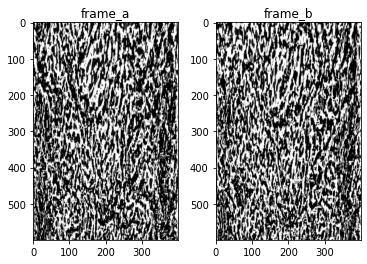

In [42]:
first_frame = 6

mask_params = {"method": "edges", "filter_size": 2, "threshold": 0.001}

frame_a = tools_piv.imread(
    os.path.join(
        "data",
        list(videos.keys())[0],
        videos[list(videos.keys())[0]][0],
        f"frame{str(first_frame).zfill(6)}.jpg",
    )
)
frame_b = tools_piv.imread(
    os.path.join(
        "data",
        list(videos.keys())[0],
        videos[list(videos.keys())[0]][0],
        f"frame{str(first_frame + 1).zfill(6)}.jpg",
    )
)
M = cv2.getPerspectiveTransform(pixel_coords, real_coords)
frame_a, _ = preprocess.dynamic_masking(frame_a, **mask_params)
frame_b, _ = preprocess.dynamic_masking(frame_b, **mask_params)
frame_a = cv2.warpPerspective(frame_a, M, (400, 600))
frame_b = cv2.warpPerspective(frame_b, M, (400, 600))

plt.subplot(121), plt.imshow(frame_a, cmap=plt.cm.gray), plt.title("frame_a")
plt.subplot(122), plt.imshow(frame_b, cmap=plt.cm.gray), plt.title("frame_b")
plt.show()

In [74]:
for vazao in videos:
    for movie in videos[vazao]:
        preffix_path = "./data/" + vazao + "/" + movie + "/"

        frames = os.listdir(preffix_path)
        frames.sort()

        pairs = []

        for j, frame in enumerate(frames):
            if j == len(frames) - 1:
                pass
            else:
                pairs.append((frame, frames[j + 1]))

        for frame_a, frame_b in pairs:
            velocity_vectors.calculate(
                preffix_path,
                frame_a,
                frame_b,
                pixel_coords,
                real_coords,
                roi=(400, 600),
                winsize=40,
                searchsize=80,
                overlap=20,
                dt=1 / 30,
                threshold=1.04,
                scaling_factor=1000,
                masking=False,
                masking_params=mask_params,
                show_fig=False,
            )
            time.sleep(0.5)

        df_final = tools.get_all_results(preffix_path + "piv_results", "median")

        df_final.to_csv(preffix_path + "piv_results" + "/final.csv", index=False)

        print("Finish!")

Folder ./data/34_4ls_32cm/20220212230118/transformed/ doesn't exists... creating...
Folder ./data/34_4ls_32cm/20220212230118/piv_results doesn't exists... creating...
./data/34_4ls_32cm/20220212230118//piv_results/20220717014421.txt created successfully
./data/34_4ls_32cm/20220212230118//piv_results/20220717014422.txt created successfully
./data/34_4ls_32cm/20220212230118//piv_results/20220717014422.txt created successfully
./data/34_4ls_32cm/20220212230118//piv_results/20220717014423.txt created successfully
./data/34_4ls_32cm/20220212230118//piv_results/20220717014424.txt created successfully
./data/34_4ls_32cm/20220212230118//piv_results/20220717014424.txt created successfully
./data/34_4ls_32cm/20220212230118//piv_results/20220717014425.txt created successfully
./data/34_4ls_32cm/20220212230118//piv_results/20220717014426.txt created successfully
./data/34_4ls_32cm/20220212230118//piv_results/20220717014426.txt created successfully
./data/34_4ls_32cm/20220212230118//piv_results/202

In [75]:
df_test = pd.read_csv(preffix_path + "piv_results" + "/final.csv")

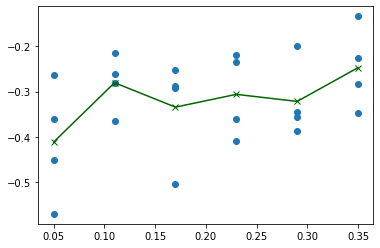

In [76]:
df_plot = (
    df_test.copy()[(df_test["y"] >= 0.1) & (df_test["y"] <= 0.3)]
    # [df_test['v'] < 0]
    # .groupby('x')['v'].mean().reset_index()
)

v_mean = df_plot.groupby("x")["v"].agg("mean").reset_index()
plt.scatter(x=df_plot["x"], y=df_plot["v"])
plt.plot(v_mean["x"], v_mean["v"], marker="x", color="darkgreen")
plt.show()

In [77]:
real_flow = float(list(videos.keys())[0].split("ls")[0].replace("_", "."))
real_height = float(
    list(videos.keys())[0]
    .split("ls")[-1]
    .split("_")[-1]
    .split("_")[-1]
    .replace("_", ".")
    .replace("cm", "")
)

flow = df_plot["v"].mean() * 0.4 * (real_height / 100) * 1000 * 0.85

print(f"Vazão medida: {real_flow}")
print(f"Vazão calculada: {flow}")

Vazão medida: 34.4
Vazão calculada: -34.45242666666667
